In [3]:
from __future__ import print_function
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

# 目标
- 学习图像金字塔。
- 用图像金字塔创建一种新的水果——“Orapple”。
- 涉及的函数：**cv2.pyrUp()**，**cv2.pyrDown()**。

# 1. 理论
通常在处理图像时使用固定大小的图像尺寸。但是在有些场合，需要使用同一图像的不同分辨率的图像。例如在搜索人脸的任务中，无法确定图像中人脸的大小。在这种情况下，就需要创建不同分辨率的图像，然后在所有图像中搜索人脸。这一组不同分辨率大小的图像被称为图像金字塔（因为会把最大的图像放在底部，最小的图像放在顶部，就像金字塔那样）。

有两种图像金字塔：高斯图像金字塔和拉普拉斯图像金字塔。

高斯图像金字塔中，通过移除低层（高分辨率）图像中的行和列来生成高层（低分辨率）图像。每个高层图像中的像素，其亮度值等于下一层对应图像中的五个像素的高斯加权求和。通过这种操作，一个$M \times N$的图像可以生成一幅$M/2 \times N/2$的图像。新图像的大小为原图像的四分之一。这被称为一个**Octave**。可以用相同的方式来产生金字塔上层的图像。与之类似，在生成金字塔下层的图像时，生成图像的尺寸是原图像的四倍。可以用**cv2.pyrDown()**和**cv2.pyrUp()**来生成图像金字塔。

用**cv2.pyrDown()**来生成金字塔上层的图像（因为分辨率降低了）：

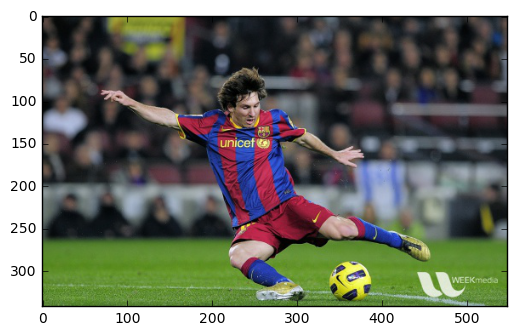

In [15]:
img = cv2.imread('../data/messi5.jpg')
plt.imshow(img[:, :, ::-1], aspect='equal')

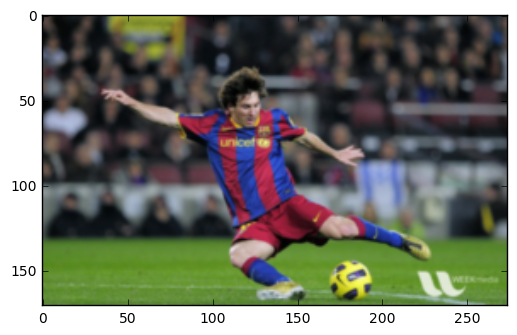

In [16]:
lower_reso = cv2.pyrDown(img)
plt.imshow(lower_reso[:, :, ::-1])

可以用**cv2.pyrUp()**来生成金字塔低层的图像（分辨率提高）：

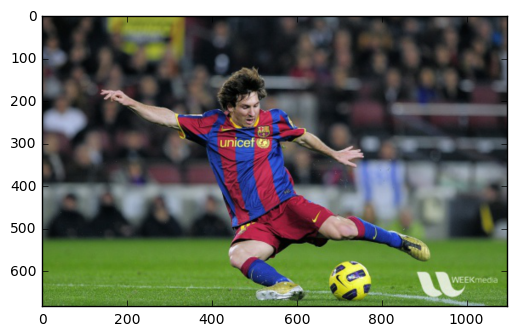

In [19]:
higher_reso = cv2.pyrUp(img)
plt.imshow(higher_reso[:, :, ::-1])

拉普拉斯金字塔由高斯金字塔生成，没有对应的函数来执行该操作。拉普拉斯金字塔的图像类似于边缘图像，大部分的值为0。下图是拉普拉斯金字塔的三个层（图像做过内容增强，以便于显示）。![](./imgs/pyramids_01.jpg)

# 2. 用图像金字塔进行图像融合
图像金字塔的应用之一就是进行图像融合。例如在图像拼接中，经常要把两幅图像拼接到一起，但是由于图像拼接区域不连续而导致效果不佳。在这种情况下，图像金字塔在进行图像无缝融合时，无需大量的图像数据。一个经典的例子就是将苹果和橘子两种水果进行拼接。效果如下图所示：![](./imgs/pyramids_02.jpg)

阅读下面提供的更多关于图像融合的资源，以了解关于图像融合、拉普拉斯金字塔等内容的全部细节。简单地说，图像融合的流程为：
1. 加载两张图像。
2. 对两张图像分别生成图像金字塔（下面的例子生成了6层）。
3. 根据高斯金字塔计算对应的拉普拉斯金字塔。
4. 将拉普拉斯金字塔中每一层的苹果和橘子进行拼接。
5. 用这个拼接出来的金字塔恢复原始图像。

下面是完整的代码，为了便于理解每个步骤单独的进行，这会使用更多的内存，如果需要可以自行优化。

(<matplotlib.text.Text at 0x117e61be0>,
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

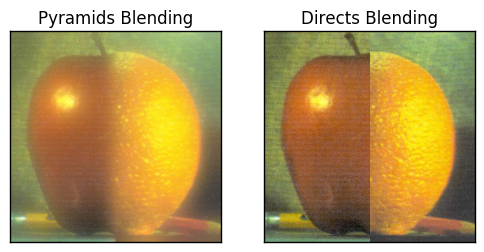

In [35]:
import cv2
import numpy as np

A = cv2.imread('../data/apple.jpg')
B = cv2.imread('../data/orange.jpg')

# 生成图像A的高斯金字塔
G = A.copy()
gpA = [G]
for i in range(5):
    G = cv2.pyrDown(G)
    gpA.append(G)
    
# 生成图像B的高斯金字塔
G = B.copy()
gpB = [G]
for i in range(5):
    G = cv2.pyrDown(G)
    gpB.append(G)

# 生成图像A的拉普拉斯金字塔
lpA = [gpA[5]]
for i in range(5, 0, -1):
    GE = cv2.pyrUp(gpA[i])
    L = cv2.subtract(gpA[i - 1], GE)
    lpA.append(L)
    
# 生成图像B的拉普拉斯金字塔
lpB = [gpB[5]]
for i in range(5, 0, -1):
    GE = cv2.pyrUp(gpB[i])
    L = cv2.subtract(gpB[i - 1], GE)
    lpB.append(L)
    
# 在每一层将图像的左右两个部分进行相加
LS = []
for la, lb in zip(lpA, lpB):
    rows, cols, dpt = la.shape
    ls = np.hstack((la[:, 0: cols // 2], lb[:, cols // 2:]))
    LS.append(ls)
    
# 重建图像
ls_ = LS[0]
for i in range(1, 6):
    ls_ = cv2.pyrUp(ls_)
    ls_ = cv2.add(ls_, LS[i])
    
# 直接拼接图像
rows, cols, dpt = A.shape
real = np.hstack((A[:, :cols // 2], B[:, cols // 2:]))

plt.subplot(121), plt.imshow(ls_[:, :, ::-1])
plt.title('Pyramids Blending'), plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(real[:, :, ::-1])
plt.title('Directs Blending'), plt.xticks([]), plt.yticks([])

# 3. 更多资源
1. [图像融合](http://pages.cs.wisc.edu/~csverma/CS766_09/ImageMosaic/imagemosaic.html)